In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# **Analysis of SCR-ROI response for shock**

In [2]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import os
from os.path import join, isdir, dirname, basename, exists
from os import mkdir
import glob as glob
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context="paper",style="white",font_scale=1.5)

cmap = plt.get_cmap('Set1')

In [3]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
SCR_betapath = join(eCON,'SCR_new/dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/{subj}_bucket_REML_clean.1D')
roi_betapath = join(eCON,'dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/ROI_{roi}/noProx/{subj}_bucket_REML.1D')
yoked = pd.read_excel(join(eCON,'SCR_new/scripts/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

In [4]:
rois = 'rvAI rdAI lvAI ldAI rPI lPI rBNST lBNST ACC\
        Amygdala_BLBM_La_R Amygdala_CeME_R Amygdala_BLBM_La_L Amygdala_CeME_L\
        rCa lCa rPa lPa rVS lVS vmPFC PCC1 PCC2 rPAG1 lPAG1'.split()

In [5]:
if not exists('data/ROIs_SCR_fmri_averaged.csv'):
    df = pd.DataFrame()
    for i, row in yoked.iterrows():
        for kind in ['control','uncontrol']:
            #print(row[kind])

            scr_beta = np.loadtxt(SCR_betapath.format(subj=row[kind],group=kind))[1::2][-1]
            roi_beta = np.vstack([np.loadtxt(roi_betapath.format(subj=row[kind],roi=roi,group=kind))[1::2][-1] for roi in rois]).T
            all_betas = np.append(scr_beta,roi_beta)

            tmp_df = pd.DataFrame(all_betas, index=['SCR']+rois).T
            tmp_df['SubjID'] = row[kind]
            tmp_df['Group'] = kind
            tmp_df['Pair'] = 'P{:02d}'.format(i)
            df = pd.concat([df,tmp_df],axis =0)
    df.to_csv('data/ROIs_SCR_fmri_averaged.csv',sep='\t',index=False)
else:
    df = pd.read_csv('data/ROIs_SCR_fmri_averaged.csv',sep='\t')

## **SCR response distributions of the two groups**
- Compare the distributions
    - Two (Independent) Sample Test
    - Related Sample Test

### **Two (Independent) Sample Test**

$$H_{0}:\mu_{SCR_{uncontrol}} \neq \mu_{SCR_{control}}$$

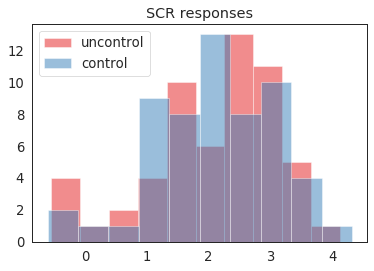

In [6]:
uncon_scr = df[df.columns[~df.columns.isin(rois)]][df['Group']=='uncontrol']['SCR'].values
con_scr = df[df.columns[~df.columns.isin(rois)]][df['Group']=='control']['SCR'].values

_=plt.hist(uncon_scr,alpha=0.5,color=cmap.colors[0],label='uncontrol')
_=plt.hist(con_scr,alpha=0.5,color=cmap.colors[1],label='control')
_=plt.title('SCR responses')
_=plt.legend()

In [7]:
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel

In [8]:
def ind_samp_perm_test(treatment, control, n_perms):
    n, k, samp_dist = len(treatment), 0, []
    real_obs = np.abs(np.mean(treatment) - np.mean(control))
    zs = np.concatenate([treatment, control])
    for j in range(n_perms):
        np.random.shuffle(zs)
        obs = np.mean(zs[:n]) - np.mean(zs[n:])
        samp_dist.append(obs)
        k += real_obs < abs(obs)
    return (samp_dist,(k+1)/(n_perms+1))

In [9]:
print('Independent Samples T-test p-value: %.3f' %(ttest_ind(uncon_scr,con_scr)[1]))

Independent Samples T-test p-value: 0.903


In [10]:
samp_dist, p_val = ind_samp_perm_test(uncon_scr,con_scr,50000)
print('Two sample permutation test p-value: %.3f' %(p_val))

Two sample permutation test p-value: 0.903


Text(0.5, 1.0, 'Two sample permutation test p-value: 0.903')

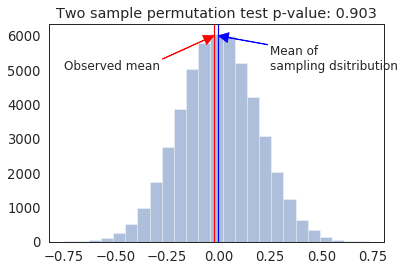

In [11]:
_=plt.hist(samp_dist,bins=25,alpha=0.45)
plt.axvline(x=np.mean(uncon_scr) - np.mean(con_scr),c='red',label='Observed mean')
plt.axvline(x=np.mean(samp_dist),c='blue',label='Mean of \nsampling dsitribution')
plt.annotate('Observed mean',
             xy=(np.mean(uncon_scr) - np.mean(con_scr),6000),
             xytext=(-0.75,5000), arrowprops={'color':'red','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
plt.annotate('Mean of \nsampling dsitribution',
             xy=(np.mean(samp_dist),6000),
             xytext=(0.25,5000), arrowprops={'color':'blue','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
plt.title('Two sample permutation test p-value: %.3f' %(p_val))

### **Paired Sample Test**
$$H_{0}: \mu_{SCR_{uncontol-control}} = 0$$

In [12]:
def rel_samp_perm_test(treatment,control,n_perms):
    n, k, samp_dist = len(treatment), 0, []
    alt_obs = abs(np.mean(np.subtract(treatment,control)))
    scr = np.stack([treatment,control],axis=0) # making a 2 X num_samples array
    for j in range(n_perms):
        null_obs = np.mean(np.array([np.random.choice([-1,1]) for i in range(n)])*(scr[0,:]-scr[1,:]))
        samp_dist.append(null_obs)
        k += abs(null_obs) > alt_obs
        
    return(samp_dist,(k+1)/(n_perms+1))

In [13]:
print('Related Samples T-test p-value: %.3f' %(ttest_rel(uncon_scr,con_scr)[1]))
samp_dist, p_val = rel_samp_perm_test(uncon_scr,con_scr,50000)
print('Related Samples permutation test p-value: %.3f' %(p_val))

Related Samples T-test p-value: 0.899
Related Samples permutation test p-value: 0.898


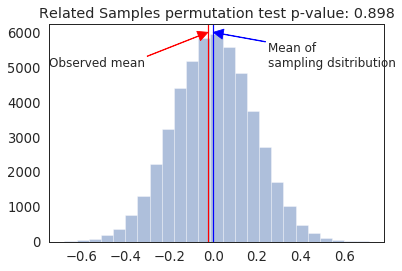

In [14]:
_=plt.hist(samp_dist,bins=25,alpha=0.45)
plt.axvline(x=np.mean(uncon_scr-con_scr),c='red',label='Observed mean')
plt.axvline(x=np.mean(samp_dist),c='blue',label='Mean of \nsampling dsitribution')
plt.annotate('Observed mean',
             xy=(np.mean(uncon_scr-con_scr),6000),
             xytext=(-0.75,5000), arrowprops={'color':'red','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
_=plt.annotate('Mean of \nsampling dsitribution',
             xy=(np.mean(samp_dist),6000),
             xytext=(0.25,5000), arrowprops={'color':'blue','width':0.5,
                                              'headwidth':10,
                                              'headlength':10},
             fontsize=12)
_=plt.title('Related Samples permutation test p-value: %.3f' %(p_val))

## **Right BST vs. SCR shock response correlation plot**
Average response estimates

In [15]:
def plot_SCR_ROI_corr(roi):
    fig = plt.figure(figsize=(6,5))
    sns.regplot('SCR',roi,df[df['Group']=='uncontrol'],color=cmap.colors[0],
                scatter_kws={'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[0]},label='uncontrol',robust=True)
    sns.regplot('SCR',roi,df[df['Group']=='control'],color=cmap.colors[1],
                scatter_kws= {'edgecolors':'black','s':50,'alpha':0.5,'color':cmap.colors[1]},label='control',robust=True)
    plt.xlabel('Skin Conductance\n[Shock] (A.U.)')
    plt.ylabel('{}\n[Shock] (A.U.)'.format(roi))
    plt.ylim(-0.75,1.75)
    plt.title('Average Etimated Response')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(join(eCON,'scripts/tmp_preproc2/figures/{}_SCR_correlation_fmri.png').format(roi),dpi=600)

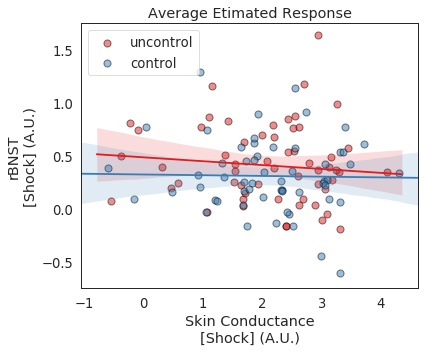

In [16]:
plot_SCR_ROI_corr('rBNST')

## **Data prep for RBA/OLS**
### **Get only rBNST and SCR columns**

In [17]:
df_rBNST = df[['Pair','Group','SubjID','rBNST','SCR']]
df_rBNST.reset_index(drop=True,inplace=True)
df_rBNST.head()

,Pair,Group,SubjID,rBNST,SCR
0,P00,control,CON001,0.608696,3.735580
1,P00,uncontrol,CON031,1.162880,1.161580
2,P01,control,CON002,0.770967,0.047607
3,P01,uncontrol,CON021,0.097088,1.679910
4,P02,control,CON003,0.587932,2.188790


### **Calculate the uncon-con difference**

In [18]:
df_rBNST_pairs = df[['Pair','rBNST','SCR']].groupby(['Pair'],as_index=True).diff()
df_rBNST_pairs.dropna(axis=0,how='all',inplace=True)
df_rBNST_pairs.index = pd.Series(df_rBNST.Pair.unique(),name='Pair')
df_rBNST_pairs.rename(columns = {'rBNST':'rBNST_diff','SCR':'SCR_diff'},inplace=True)
df_rBNST_pairs.head()

,rBNST_diff,SCR_diff
Pair,,
P00,0.554184,-2.574000
P01,-0.673879,1.632302
P02,-0.640979,0.914620
P03,0.163446,1.775880
P04,0.189221,-0.039070


### **Get the STAI scores to be used as covariates**

In [19]:
scores = pd.read_excel(join(eCON,'STAIscores/scores.xlsx'))
scores.rename(columns={'SCORING':'TRAIT'},inplace=True)
scores.drop(columns=['PAIR SCORE'],inplace=True)
scores['SubID'] = scores['SubID'].apply(lambda name: ''.join(name.strip().split("_")))
print(scores.head())
print(scores.tail())

    SubID    Group  TRAIT  STATE
0  CON001  control     27     24
1  CON002  control     27     26
2  CON003  control     36     26
3  CON004  control     21     21
4  CON005  control     33     26
      SubID      Group  TRAIT  STATE
121  CON119  uncontrol     38     30
122  CON120  uncontrol     35     35
123  CON121  uncontrol     53     55
124  CON123  uncontrol     30     23
125  CON125  uncontrol     38     30


In [20]:
new_score_df = pd.DataFrame()
for i,row in yoked.iterrows():
    conTrait = scores[scores['SubID'] == row['control']]['TRAIT'].values[0]
    unconTrait = scores[scores['SubID'] == row['uncontrol']]['TRAIT'].values[0]
    
    conState = scores[scores['SubID'] == row['control']]['STATE'].values[0]
    unconState = scores[scores['SubID'] == row['uncontrol']]['STATE'].values[0]
    
    tmp_df = pd.DataFrame(['P{:02d}'.format(i),row['uncontrol'],row['control'],
                           unconTrait,conTrait,unconTrait-conTrait,np.mean([unconTrait,conTrait]),
                           unconState,conState,unconState-conState,np.mean([unconState,conState])],
                          index=['Pair',('SubID','uncontrol'),('SubID','control'),
                                  ('TRAIT','uncontrol'),('TRAIT','control'),('TRAIT','uncon-con'),('TRAIT','mean'),
                                  ('STATE','uncontrol'),('STATE','control'),('STATE','uncon-con'),('STATE','mean')]).T
    
    new_score_df = pd.concat([new_score_df,tmp_df],axis=0)
    
new_score_df.set_index('Pair',inplace=True)


new_score_df.columns = pd.MultiIndex.from_tuples(new_score_df.columns)

In [21]:
print(new_score_df.head())
print(new_score_df.tail())

         SubID             TRAIT                             STATE          \
     uncontrol control uncontrol control uncon-con  mean uncontrol control   
Pair                                                                         
P00     CON031  CON001        27      27         0    27        22      24   
P01     CON021  CON002        36      27         9  31.5        30      26   
P02     CON022  CON003        37      36         1  36.5        29      26   
P03     CON030  CON004        24      21         3  22.5        20      21   
P04     CON023  CON005        33      33         0    33        32      26   

                      
     uncon-con  mean  
Pair                  
P00         -2    23  
P01          4    28  
P02          3  27.5  
P03         -1  20.5  
P04          6    29  
         SubID             TRAIT                             STATE          \
     uncontrol control uncontrol control uncon-con  mean uncontrol control   
Pair                               

### **Normalize the STAI score**

In [22]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scores_norm = pd.DataFrame(ss.fit_transform(new_score_df[[('STATE', 'mean'),('STATE','uncon-con'),('TRAIT', 'mean'),('TRAIT','uncon-con')]]),
                          columns=['STATEmean','STATEdiff','TRAITmean','TRAITdiff'],index=new_score_df.index)


In [23]:
scores_norm.head()

,STATEmean,STATEdiff,TRAITmean,TRAITdiff
Pair,,,,
P00,-1.213278,-0.144191,-0.988402,-0.055850
P01,-0.419284,0.496243,-0.407588,3.127601
P02,-0.498684,0.389504,0.237760,0.297867
P03,-1.610275,-0.037452,-1.569215,1.005300
P04,-0.260486,0.709720,-0.213984,-0.055850


### **Combine the df that has SCR and ROI responses (df_rBNST_pairs) with the df that has normalized STAI scores (scores_norm)**

In [24]:
final_df = df_rBNST_pairs.join(scores_norm)
final_df.reset_index(drop=False,inplace=True)
print(final_df.head())
final_df.rename(columns={'rBNST':'y','Pair':'Subj'},inplace=True)
print(final_df.head())

  Pair  rBNST_diff  SCR_diff  STATEmean  STATEdiff  TRAITmean  TRAITdiff
0  P00    0.554184 -2.574000  -1.213278  -0.144191  -0.988402  -0.055850
1  P01   -0.673879  1.632302  -0.419284   0.496243  -0.407588   3.127601
2  P02   -0.640979  0.914620  -0.498684   0.389504   0.237760   0.297867
3  P03    0.163446  1.775880  -1.610275  -0.037452  -1.569215   1.005300
4  P04    0.189221 -0.039070  -0.260486   0.709720  -0.213984  -0.055850
  Subj  rBNST_diff  SCR_diff  STATEmean  STATEdiff  TRAITmean  TRAITdiff
0  P00    0.554184 -2.574000  -1.213278  -0.144191  -0.988402  -0.055850
1  P01   -0.673879  1.632302  -0.419284   0.496243  -0.407588   3.127601
2  P02   -0.640979  0.914620  -0.498684   0.389504   0.237760   0.297867
3  P03    0.163446  1.775880  -1.610275  -0.037452  -1.569215   1.005300
4  P04    0.189221 -0.039070  -0.260486   0.709720  -0.213984  -0.055850


In [30]:
final_df.to_csv('data/uncon_v_con_rBNST_SCR_with_covariates.txt',sep='\t',index=False,float_format='%.4f')